In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import VAE.layers

2025-11-05 16:41:57.394240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 16:41:57.454349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 16:41:58.848622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
!mkdir -p datasets/cache

I0000 00:00:1762371723.194751   78689 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-11-05 16:42:04.126374: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-05 16:42:04.208586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-05 16:42:04.234501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequen

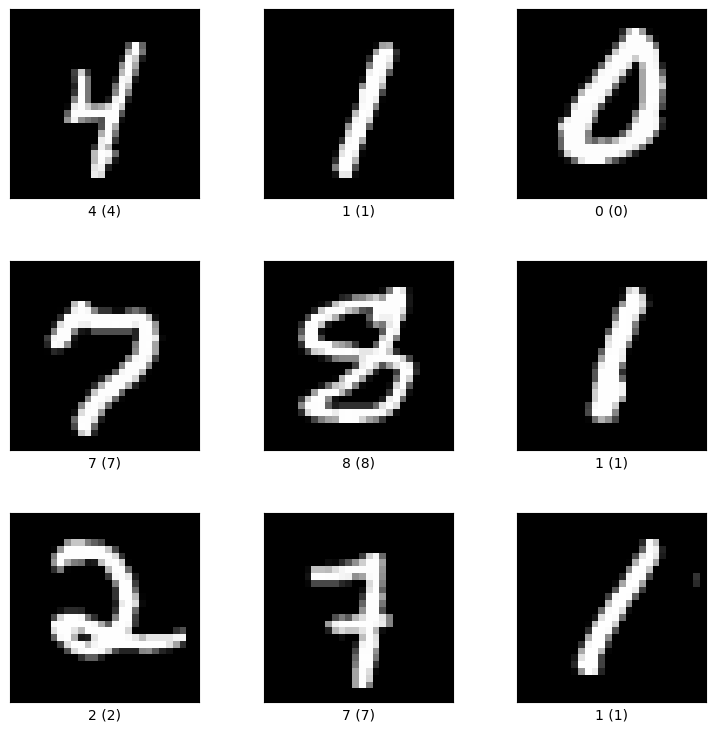

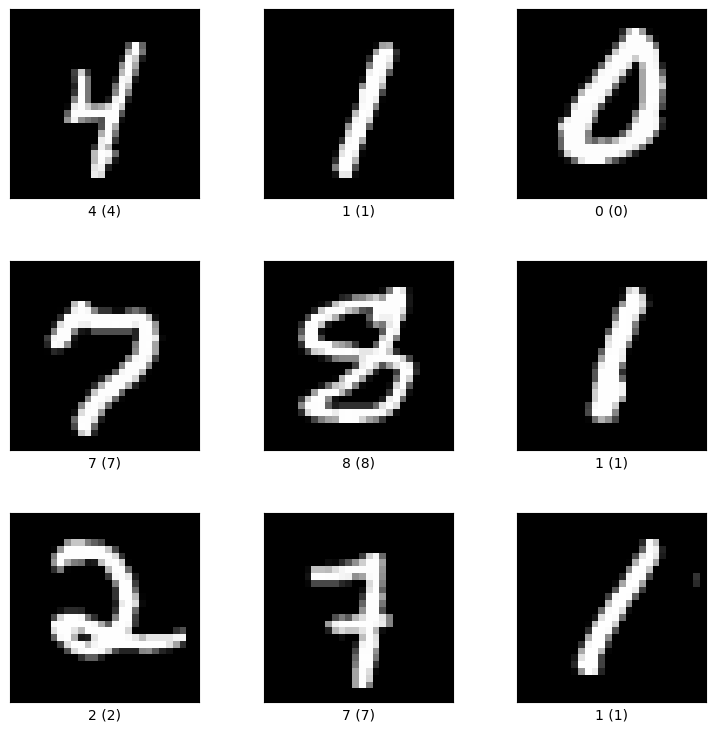

In [5]:
mnist, info = tfds.load('mnist', with_info=True, data_dir='datasets')
tfds.visualization.show_examples(mnist['train'].concatenate(mnist['test']), info)

Due to the @tf.function decorator on the training_step function it is necessary to re-run the training loop and encoder/decoder declarations (cells 6 through 10) every time before the training routine is called (cell 12). 

I will probably encapsulate all of these steps in a class in the near future.

In [ ]:
# NOTE: Learning log-variance is more numerically stable than enforcing variance > 0

@tf.function
def training_step(x_i, encoder_model, decoder_model, optimizer, epoch_ratio):
    # Increase KL Div weight from min_anneal to max_anneal from t0 to t1 epochs
    t0, t1 = 0.4, 0.6 # in % of total epochs
    min_anneal, max_anneal = 0.0, 1.0
    if epoch_ratio < t0:
        kl_annealing = min_anneal
    elif epoch_ratio < t1:
        kl_annealing = (epoch_ratio - t0) * (max_anneal - min_anneal) / (t1 - t0)
    else:
        kl_annealing = max_anneal

    with tf.GradientTape() as tape:
        # Encoder pass
        mu, logvar = tf.split(encoder_model(x_i, training=True), num_or_size_splits=2, axis=-1)

        # Decoder pass
        z_i = mu + tf.math.exp(logvar * 0.5) * tf.random.normal(logvar.shape, 0.0, 1.0)
        x_hat = decoder_model(z_i, training=True)

        # KL Divergence
        divergence_loss = tf.math.reduce_mean(
            -0.5 * tf.math.reduce_sum(1.0 - tf.math.exp(logvar) - mu * mu + logvar, axis=1)
        )

        # Reconstruction loss
        reconstruction_loss = tf.math.reduce_mean(
            tf.reduce_sum(tf.keras.losses.binary_crossentropy(x_i, x_hat), axis=[1, 2])
        )

        # VAE loss
        network_loss = kl_annealing * divergence_loss + reconstruction_loss

        # Regularization losses
        # Encoder
        regularization_encoder = encoder_model.losses
        if regularization_encoder:
            network_loss += tf.nn.scale_regularization_loss(tf.add_n(regularization_encoder))
        # Decoder
        regularization_decoder = decoder_model.losses
        if regularization_decoder:
            network_loss += tf.nn.scale_regularization_loss(tf.add_n(regularization_decoder))

    trainable_variables = encoder_model.trainable_variables + decoder_model.trainable_variables
    gradient = tape.gradient(network_loss, trainable_variables)
    optimizer.apply(gradient, trainable_variables)

    return divergence_loss, reconstruction_loss, network_loss

In [7]:
latent_dim = 8 # Number of gaussians
assert latent_dim > 1

In [8]:
units = [16, 32, 64, 128]
assert units[-1] % 2 == 0

n_conv = len(units)
kernel_size = [(3,3)] * n_conv
stride = [(2,2)] * n_conv
padding = ['same'] * n_conv
activation = ['relu'] * n_conv
input_shape = (32, 32, 1)

threshold = 'sigmoid'

assert n_conv == len(kernel_size) == len(stride) == len(padding) == len(activation)
encoder_model_param_list = list(zip(units, kernel_size, stride, padding, activation))

# Create the encoder_model
encoder_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(1, (5,5), (1,1), 'same', kernel_initializer='he_normal', activation=threshold)
])
for u, k, s, p, a in encoder_model_param_list:
    k_init = 'he_normal' if a.lower()[-3:] == 'elu' else 'glorot_normal'
    encoder_model.add(tf.keras.layers.Conv2D(u, k, s, p, kernel_initializer=k_init))#, kernel_regularizer=tf.keras.regularizers.L2()))
    encoder_model.add(tf.keras.layers.LayerNormalization())
    encoder_model.add(tf.keras.layers.Activation(a))
encoder_model.add(tf.keras.layers.Flatten())
encoder_model.add(tf.keras.layers.Dense(2 * latent_dim, kernel_initializer='he_normal', dtype=tf.float32))

encoder_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 1)      │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16, 16, 16)     │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 8, 8, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 4, 4, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 2, 2, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,866 (413.54 KB)

 Trainable params: 105,866 (413.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
units = [128, 64, 32, 16]
n_conv = len(units)

kernel_size = [(3,3)] * n_conv
stride = [(2,2)] * n_conv
padding = ['same'] * n_conv
activation = ['relu'] * n_conv
output_shape = (32, 32, 1)

tmp = output_shape[0]
for s in stride:
    tmp /= s[0]
tmp = int(tmp)

assert n_conv == len(kernel_size) == len(stride) == len(padding) == len(activation)
decoder_model_param_list = list(zip(units, kernel_size, stride, padding, activation))

# Same as the encoder's flatten output
dense_units = np.prod([layer for layer in encoder_model.layers if 'flatten' in layer.name][0].__dict__['_build_shapes_dict']['input_shape'][1:])

# Create the decoder_model
decoder_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(latent_dim,)),
    tf.keras.layers.Dense(dense_units, kernel_initializer='he_normal'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Reshape(target_shape=(tmp, tmp, dense_units // tmp**2)),
])
for u, k, s, p, a in decoder_model_param_list:
    k_init = 'he_normal' if a.lower()[-3:] == 'elu' else 'glorot_normal'
    decoder_model.add(tf.keras.layers.UpSampling2D(s))
    decoder_model.add(tf.keras.layers.Conv2D(u, k, (1,1), p, kernel_initializer=k_init))#, kernel_regularizer=tf.keras.regularizers.L2()))
    decoder_model.add(tf.keras.layers.LayerNormalization())
    decoder_model.add(tf.keras.layers.Activation(a))
decoder_model.add(tf.keras.layers.Conv2D(1, (5,5), (1,1), 'same', kernel_initializer='he_normal', activation=threshold, dtype=tf.float32))

decoder_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 512)            │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 4, 4, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 8, 8, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 16, 16, 32)     │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 32, 32, 16)     │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 1)      │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,977 (980.38 KB)

 Trainable params: 250,977 (980.38 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)#, momentum=0.9)

In [11]:
normalize_image = lambda image: tf.cast(image, tf.float32) / 255.0
denormalize_image = lambda image: tf.cast(image * 255.0, tf.uint8)

In [12]:
epochs = 120
batch_size = 512
training_samples = mnist['train'].cardinality()

# Distributed learning is probably overkill for this one, so I won't be using a distributed dataset.
train_ds = mnist['train'].map(lambda data: tf.pad(tf.reshape(data['image'], (28, 28, 1)), [[2, 2], [2, 2], [0, 0]]), num_parallel_calls=tf.data.AUTOTUNE)\
                         .map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)\
                         .cache()\
                         .shuffle(training_samples, reshuffle_each_iteration=True)\
                         .batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)\
                         .prefetch(tf.data.AUTOTUNE)\
                         .repeat(epochs)

n_steps = int(train_ds.cardinality())
n_steps_per_epoch = n_steps // epochs

Epoch 1/120


2025-11-05 16:42:13.963672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - divergence_loss: 86.4571 - reconstruction_loss: 205.2061 - network_loss: 205.2061
Epoch 2/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 53.4566 - reconstruction_loss: 173.0731 - network_loss: 173.0731
Epoch 3/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 55.5754 - reconstruction_loss: 118.3556 - network_loss: 118.3556
Epoch 4/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 59.6909 - reconstruction_loss: 108.9783 - network_loss: 108.9783
Epoch 5/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 63.2788 - reconstruction_loss: 102.9455 - network_loss: 102.9455
Epoch 6/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 65.1688 - reconstruction_loss: 99.3513 - network_loss: 99.3513 
Epoch 7/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 67.0590 - reconstruction_loss: 95.5411 - network_loss: 95.5411
Epoch 8/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 1

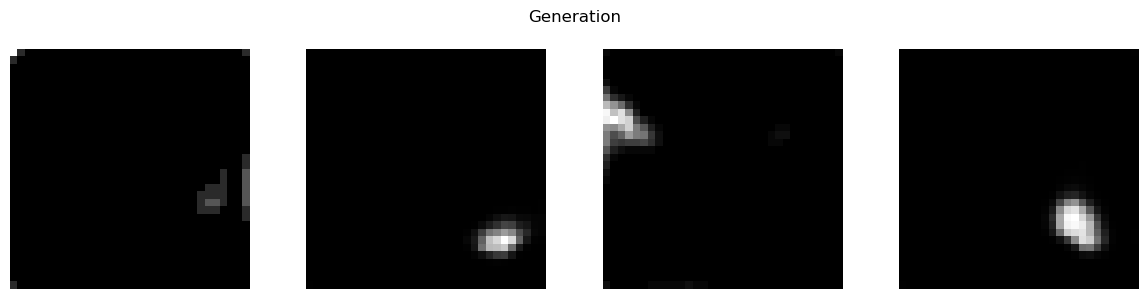

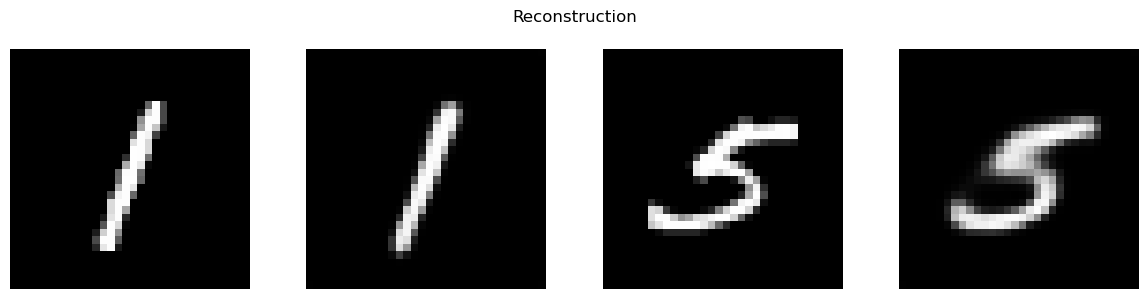

Epoch 11/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 69.8250 - reconstruction_loss: 94.6568 - network_loss: 94.6568
Epoch 12/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 70.3343 - reconstruction_loss: 90.0292 - network_loss: 90.0292
Epoch 13/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 71.1532 - reconstruction_loss: 89.1101 - network_loss: 89.1101
Epoch 14/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 70.7196 - reconstruction_loss: 88.5001 - network_loss: 88.5001
Epoch 15/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 71.2719 - reconstruction_loss: 86.0088 - network_loss: 86.0088
Epoch 16/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 71.3647 - reconstruction_loss: 91.7602 - network_loss: 91.7602
Epoch 17/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 72.5836 - reconstruction_loss: 89.3756 - network_loss: 89.3756
Epoch 18/120
117/117 ━━━━━━━━━━━━━

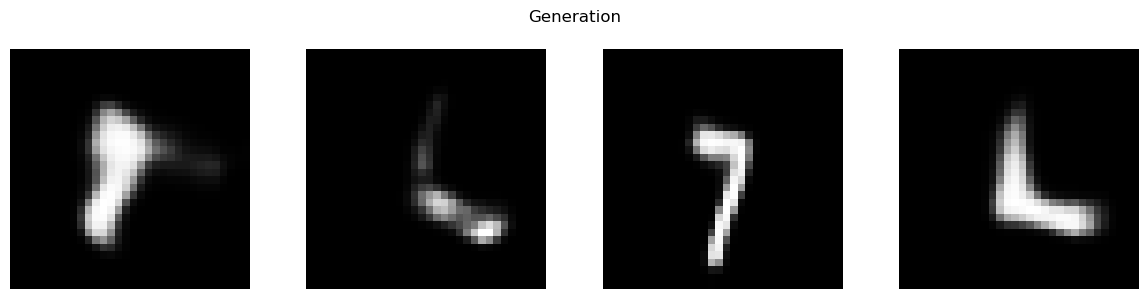

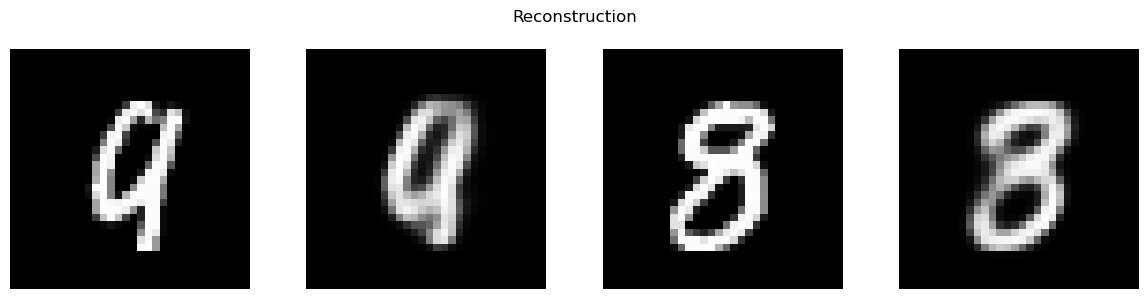

Epoch 21/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - divergence_loss: 72.7572 - reconstruction_loss: 84.7814 - network_loss: 84.7814
Epoch 22/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 73.0115 - reconstruction_loss: 88.5689 - network_loss: 88.5689
Epoch 23/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 72.1306 - reconstruction_loss: 84.4073 - network_loss: 84.4073
Epoch 24/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 72.9603 - reconstruction_loss: 85.5409 - network_loss: 85.5409
Epoch 25/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 72.6694 - reconstruction_loss: 86.3189 - network_loss: 86.3189
Epoch 26/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 73.3577 - reconstruction_loss: 85.2678 - network_loss: 85.2678
Epoch 27/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - divergence_loss: 73.4208 - reconstruction_loss: 83.1709 - network_loss: 83.1709
Epoch 28/120
117/117 ━━━━━━━━━━━━━

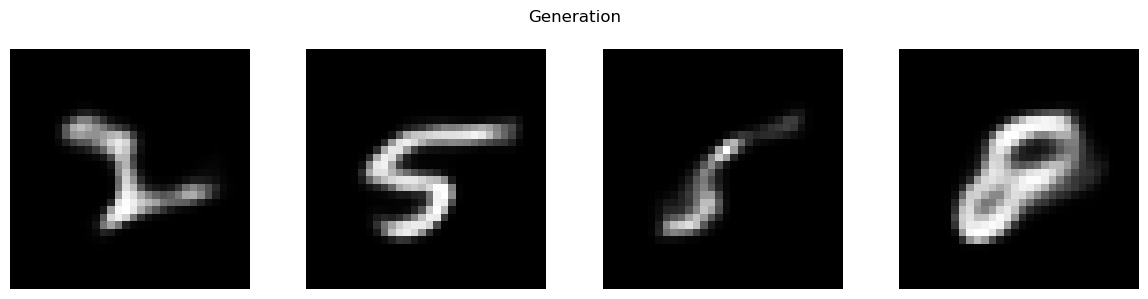

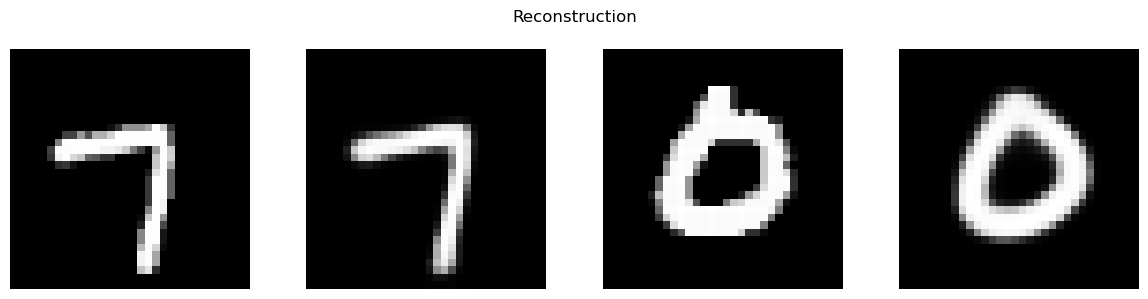

Epoch 31/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - divergence_loss: 72.6468 - reconstruction_loss: 84.9846 - network_loss: 84.9846
Epoch 32/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 72.1433 - reconstruction_loss: 84.0802 - network_loss: 84.0802
Epoch 33/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 72.2317 - reconstruction_loss: 83.4084 - network_loss: 83.4084
Epoch 34/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 72.1085 - reconstruction_loss: 82.2476 - network_loss: 82.2476
Epoch 35/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 70.3041 - reconstruction_loss: 83.9578 - network_loss: 83.9578
Epoch 36/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 71.3346 - reconstruction_loss: 82.3848 - network_loss: 82.3848
Epoch 37/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 69.8931 - reconstruction_loss: 80.3339 - network_loss: 80.3339
Epoch 38/120
117/117 ━━━━━━━━━━━━━

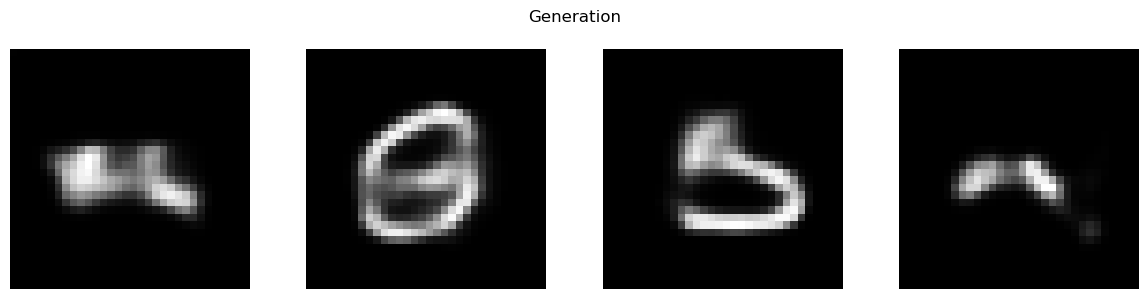

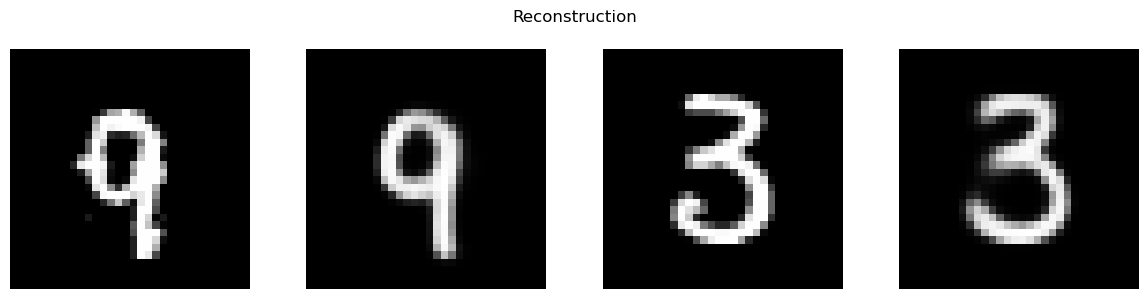

Epoch 41/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 69.1323 - reconstruction_loss: 79.2507 - network_loss: 79.2507
Epoch 42/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 69.3130 - reconstruction_loss: 81.1227 - network_loss: 81.1227
Epoch 43/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 69.2152 - reconstruction_loss: 82.0264 - network_loss: 82.0264
Epoch 44/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - divergence_loss: 69.2143 - reconstruction_loss: 79.9954 - network_loss: 79.9954
Epoch 45/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 69.8083 - reconstruction_loss: 82.0066 - network_loss: 82.0066
Epoch 46/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 70.2588 - reconstruction_loss: 79.9115 - network_loss: 79.9115
Epoch 47/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - divergence_loss: 70.7150 - reconstruction_loss: 80.1518 - network_loss: 80.1518
Epoch 48/120
117/117 ━━━━━━━━━━━━━

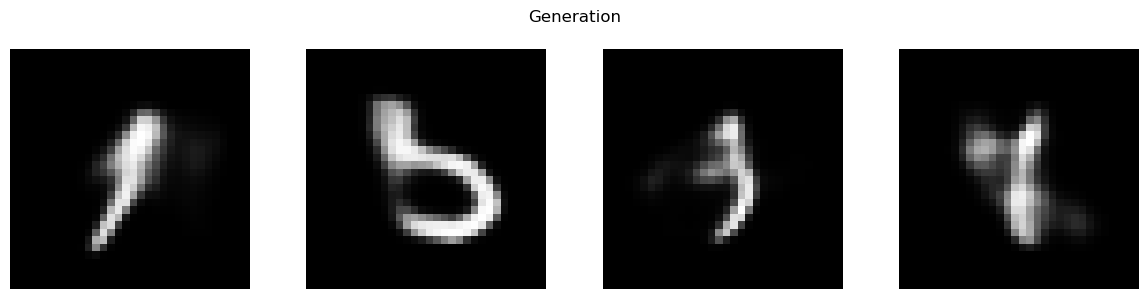

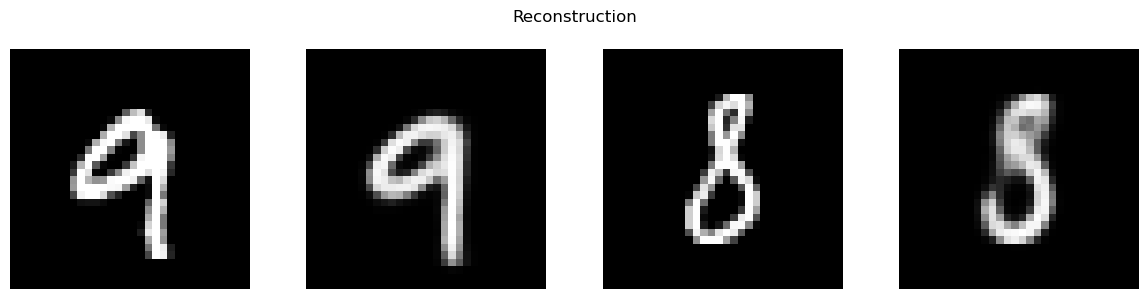

Epoch 51/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 30.9449 - reconstruction_loss: 78.9194 - network_loss: 81.4981
Epoch 52/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 29.2019 - reconstruction_loss: 79.3881 - network_loss: 83.0383
Epoch 53/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - divergence_loss: 27.6184 - reconstruction_loss: 82.3014 - network_loss: 86.9045
Epoch 54/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 26.8204 - reconstruction_loss: 78.2587 - network_loss: 83.8463
Epoch 55/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 26.1021 - reconstruction_loss: 79.3693 - network_loss: 85.8949
Epoch 56/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 25.1274 - reconstruction_loss: 77.6046 - network_loss: 84.9334
Epoch 57/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 24.3646 - reconstruction_loss: 79.4141 - network_loss: 87.5357
Epoch 58/120
117/117 ━━━━━━━━━━━━━

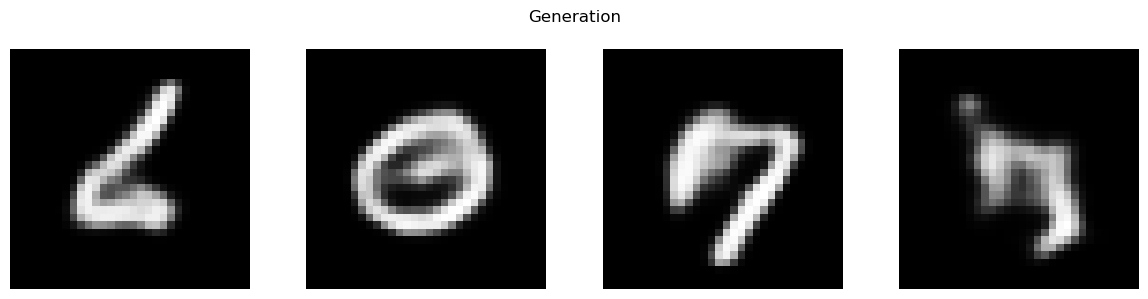

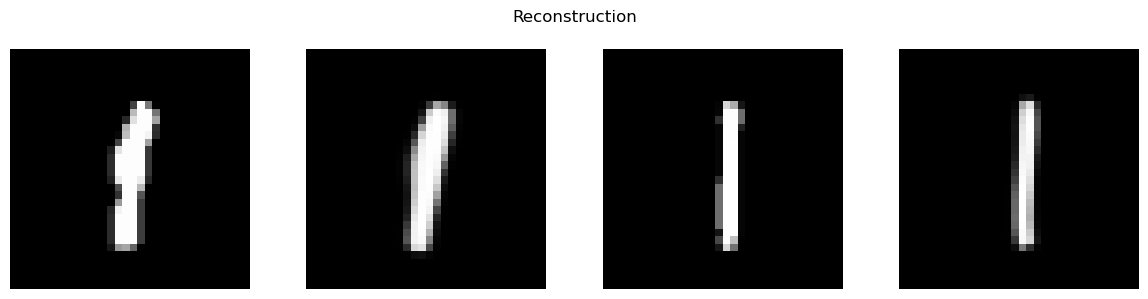

Epoch 61/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - divergence_loss: 22.2651 - reconstruction_loss: 81.1146 - network_loss: 92.2472
Epoch 62/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 21.3629 - reconstruction_loss: 78.3344 - network_loss: 89.9060
Epoch 63/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - divergence_loss: 21.2019 - reconstruction_loss: 79.3047 - network_loss: 91.6724
Epoch 64/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - divergence_loss: 20.9080 - reconstruction_loss: 80.2632 - network_loss: 93.3307
Epoch 65/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 20.5327 - reconstruction_loss: 80.2987 - network_loss: 93.9872
Epoch 66/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 20.3669 - reconstruction_loss: 83.2767 - network_loss: 97.7032
Epoch 67/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 20.0043 - reconstruction_loss: 80.6685 - network_loss: 95.6717
Epoch 68/120
117/117 ━━━━━━━━━━━━━

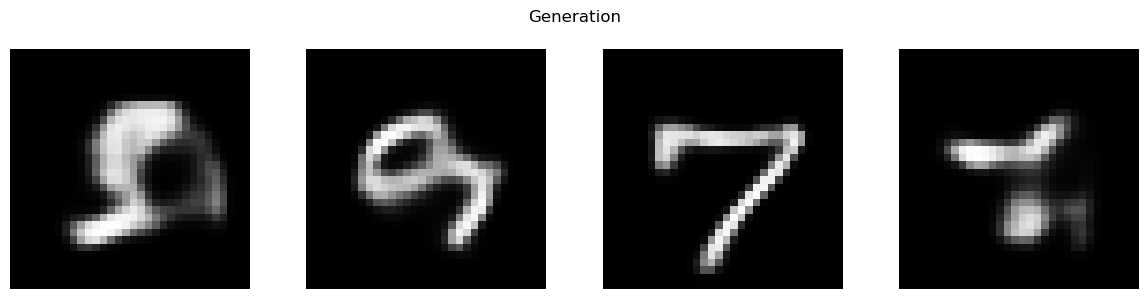

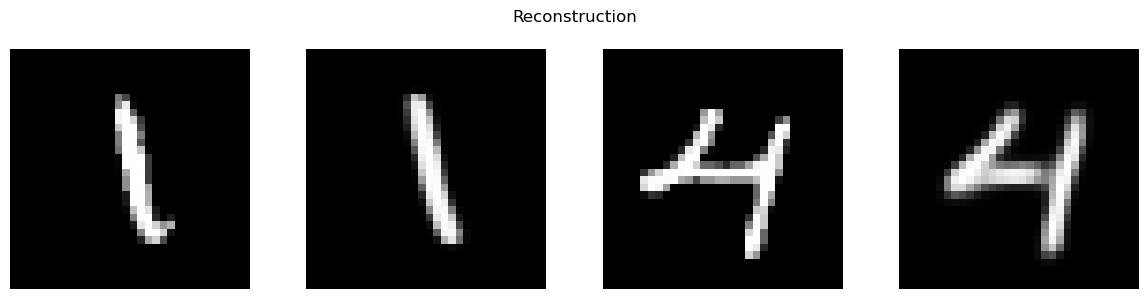

Epoch 71/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 19.0112 - reconstruction_loss: 82.6200 - network_loss: 100.0470
Epoch 72/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.4561 - reconstruction_loss: 81.0274 - network_loss: 98.7145
Epoch 73/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.1273 - reconstruction_loss: 81.4570 - network_loss: 99.5842
Epoch 74/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.4501 - reconstruction_loss: 82.6992 - network_loss: 101.1493
Epoch 75/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.2479 - reconstruction_loss: 81.1007 - network_loss: 99.3486
Epoch 76/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.3312 - reconstruction_loss: 84.0307 - network_loss: 102.3619
Epoch 77/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.3141 - reconstruction_loss: 80.6332 - network_loss: 98.9473
Epoch 78/120
117/117 ━━━━━━━━━━

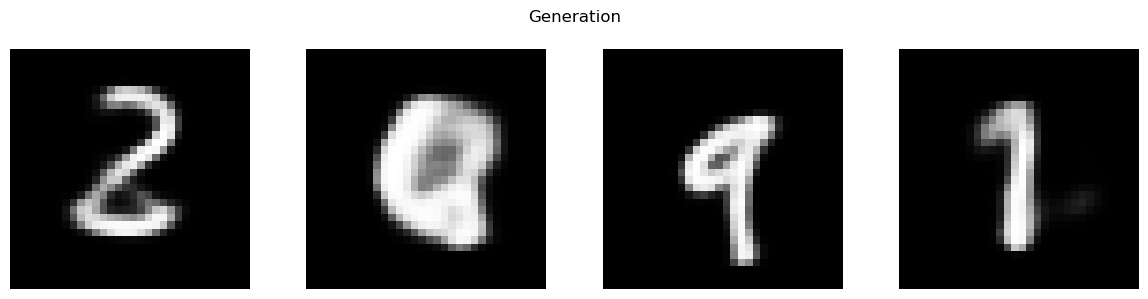

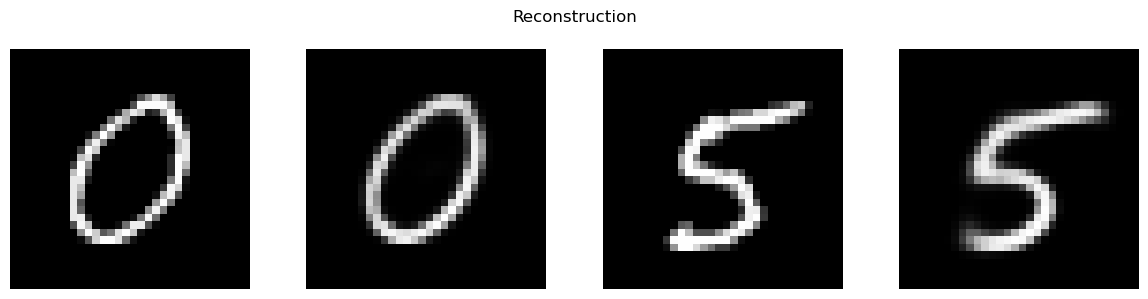

Epoch 81/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.1119 - reconstruction_loss: 81.1912 - network_loss: 99.3031
Epoch 82/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - divergence_loss: 18.1691 - reconstruction_loss: 81.8829 - network_loss: 100.0519
Epoch 83/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.3587 - reconstruction_loss: 83.1343 - network_loss: 101.4930
Epoch 84/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 18.3715 - reconstruction_loss: 81.0544 - network_loss: 99.4258
Epoch 85/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 18.0032 - reconstruction_loss: 82.2911 - network_loss: 100.2943
Epoch 86/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 18.1978 - reconstruction_loss: 81.0545 - network_loss: 99.2523
Epoch 87/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - divergence_loss: 18.2117 - reconstruction_loss: 81.5367 - network_loss: 99.7484
Epoch 88/120
117/117 ━━━━━━━━━━

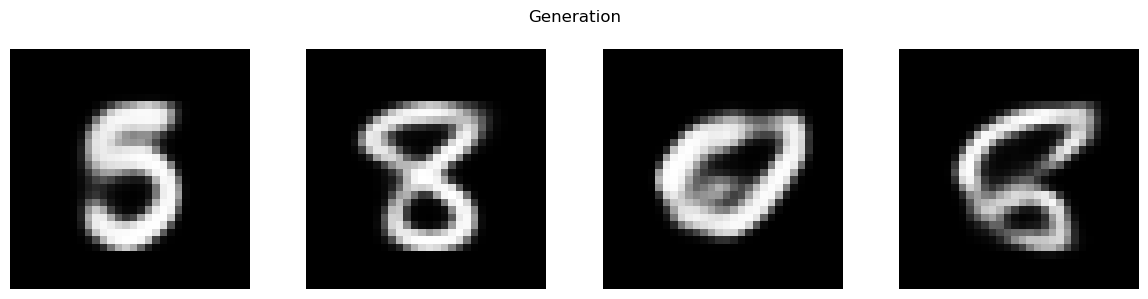

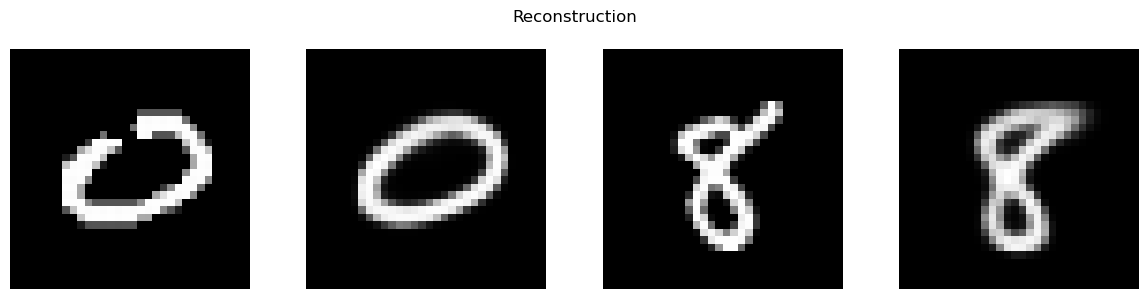

Epoch 91/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.1691 - reconstruction_loss: 78.7882 - network_loss: 96.9573
Epoch 92/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 18.1807 - reconstruction_loss: 81.0325 - network_loss: 99.2132
Epoch 93/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.2325 - reconstruction_loss: 81.6799 - network_loss: 99.9124
Epoch 94/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.1300 - reconstruction_loss: 80.9282 - network_loss: 99.0582
Epoch 95/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 18.0357 - reconstruction_loss: 78.5627 - network_loss: 96.5983
Epoch 96/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.1966 - reconstruction_loss: 78.6633 - network_loss: 96.8599
Epoch 97/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 18.2308 - reconstruction_loss: 81.2934 - network_loss: 99.5242
Epoch 98/120
117/117 ━━━━━━━━━━━━━

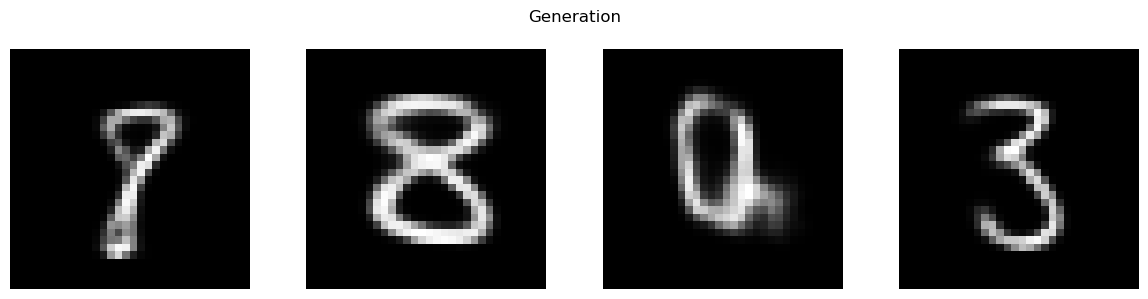

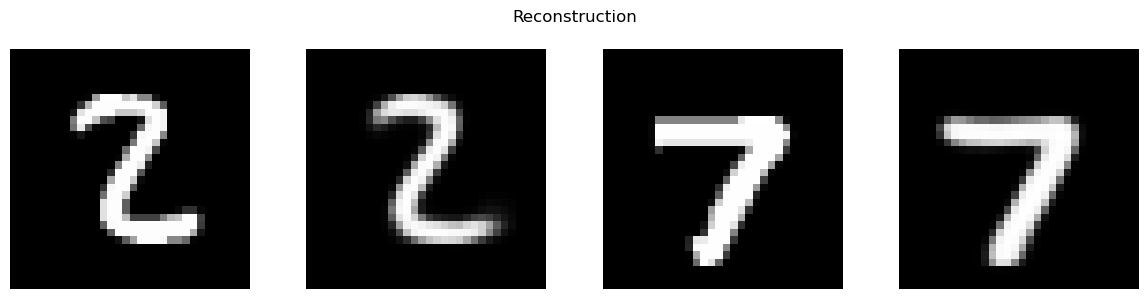

Epoch 101/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - divergence_loss: 18.0898 - reconstruction_loss: 80.3612 - network_loss: 98.4509
Epoch 102/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - divergence_loss: 18.2654 - reconstruction_loss: 81.2222 - network_loss: 99.4875
Epoch 103/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.3249 - reconstruction_loss: 81.7319 - network_loss: 100.0569
Epoch 104/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.2738 - reconstruction_loss: 81.1788 - network_loss: 99.4525
Epoch 105/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - divergence_loss: 17.7670 - reconstruction_loss: 78.7345 - network_loss: 96.5015
Epoch 106/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.3580 - reconstruction_loss: 79.6584 - network_loss: 98.0164
Epoch 107/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - divergence_loss: 17.9815 - reconstruction_loss: 80.5709 - network_loss: 98.5524
Epoch 108/120
117/117 ━━━━

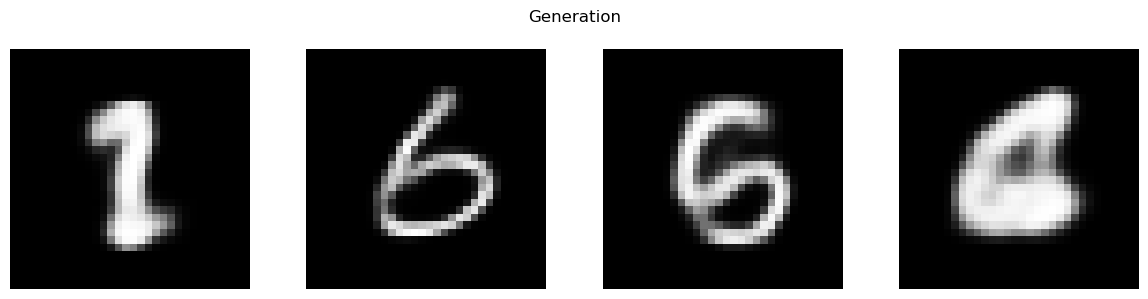

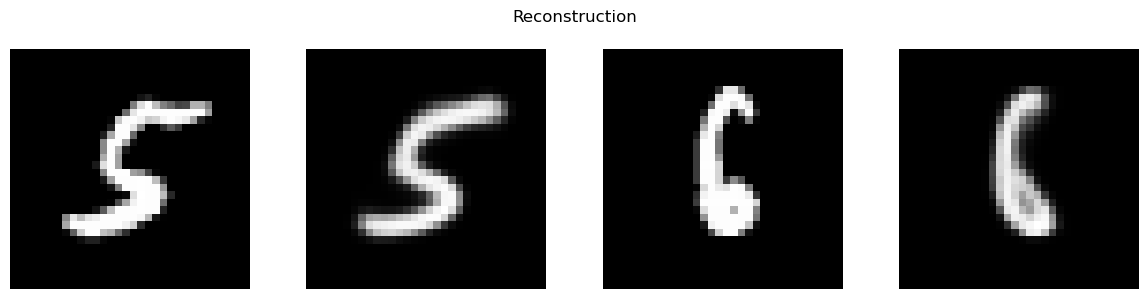

Epoch 111/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - divergence_loss: 17.9451 - reconstruction_loss: 78.0051 - network_loss: 95.9502
Epoch 112/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.2606 - reconstruction_loss: 80.2740 - network_loss: 98.5347
Epoch 113/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 17.9955 - reconstruction_loss: 78.6292 - network_loss: 96.6247
Epoch 114/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 17.9092 - reconstruction_loss: 78.1749 - network_loss: 96.0840
Epoch 115/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.0930 - reconstruction_loss: 79.7122 - network_loss: 97.8052
Epoch 116/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - divergence_loss: 18.0094 - reconstruction_loss: 77.4466 - network_loss: 95.4560
Epoch 117/120
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - divergence_loss: 18.4445 - reconstruction_loss: 80.3018 - network_loss: 98.7463
Epoch 118/120
117/117 ━━━━━

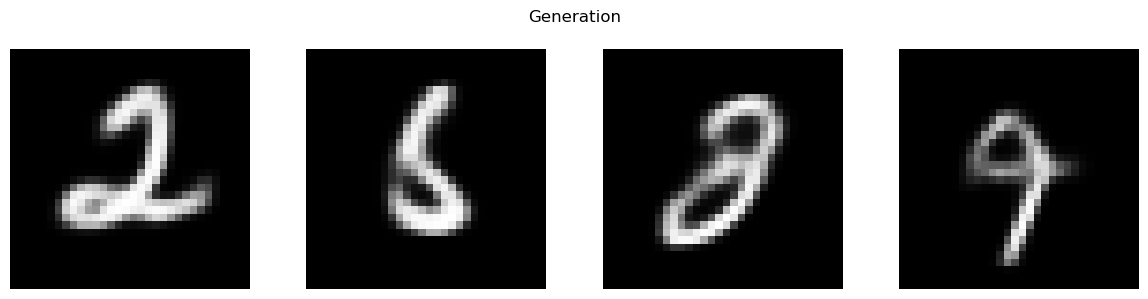

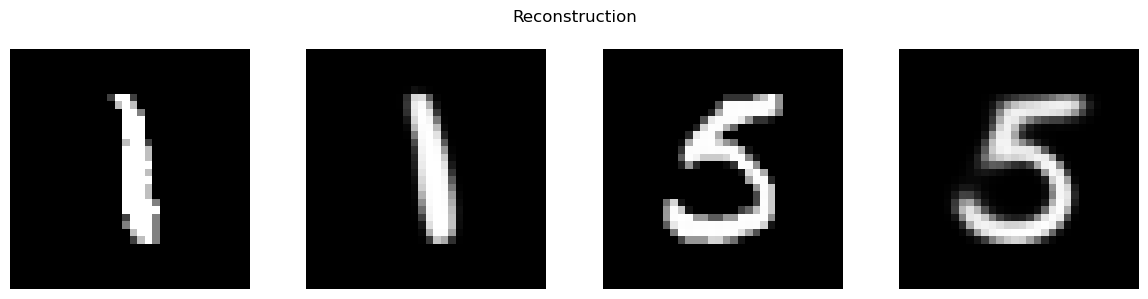

2025-11-05 17:04:32.828800: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Training

tf.keras.backend.clear_session()

progbar = tf.keras.utils.Progbar(target=n_steps_per_epoch)
n_examples = 4
history = []
epoch = 0

for i, batch in enumerate(train_ds):
    if progbar._seen_so_far == 0: # At the start of each epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # For KL Annealing
        epoch_ratio = epoch / epochs

    losses = training_step(batch, encoder_model, decoder_model, optimizer, epoch_ratio)

    progbar.update(progbar._seen_so_far + 1, zip(['divergence_loss', 'reconstruction_loss', 'network_loss'], losses), finalize=False)

    if progbar._seen_so_far == n_steps_per_epoch: # At the end of each epoch
        # Update the progress bar
        progbar.update(progbar._seen_so_far, zip(['divergence_loss', 'reconstruction_loss', 'network_loss'], losses), finalize=True)
        progbar = tf.keras.utils.Progbar(target=n_steps_per_epoch)

        # Evolution of the losses
        history.append(losses)

        # Generate and plot examples every N epochs
        if (epoch + 1) % 10 == 0:
            # Image generation
            fig, axes = plt.subplots(1, n_examples, figsize=(12, 3))
            synth_batch = decoder_model(tf.random.normal([n_examples, latent_dim], 0.0, 1.0))
            for j in range(n_examples):
                axes.ravel()[j].axis('off')
                axes.ravel()[j].imshow(denormalize_image(synth_batch[j]), cmap='gray')
            fig.suptitle("Generation")
            plt.tight_layout()
            plt.show()

            mu, logvar = tf.split(encoder_model(batch[:2]), 2, -1)
            z_i = tf.random.normal(logvar.shape, mu, tf.math.exp(logvar * 0.5))
            synth_batch = decoder_model(z_i)

            # Image reconstruction
            fig, axes = plt.subplots(1, 4, figsize=(12, 3))
            for j in range(2):
                axes.ravel()[2*j].axis('off')
                axes.ravel()[2*j].imshow(denormalize_image(batch[j]), cmap='gray')
                axes.ravel()[2*j+1].axis('off')
                axes.ravel()[2*j+1].imshow(denormalize_image(synth_batch[j]), cmap='gray')
            fig.suptitle("Reconstruction")
            plt.tight_layout()
            plt.show()

        epoch += 1

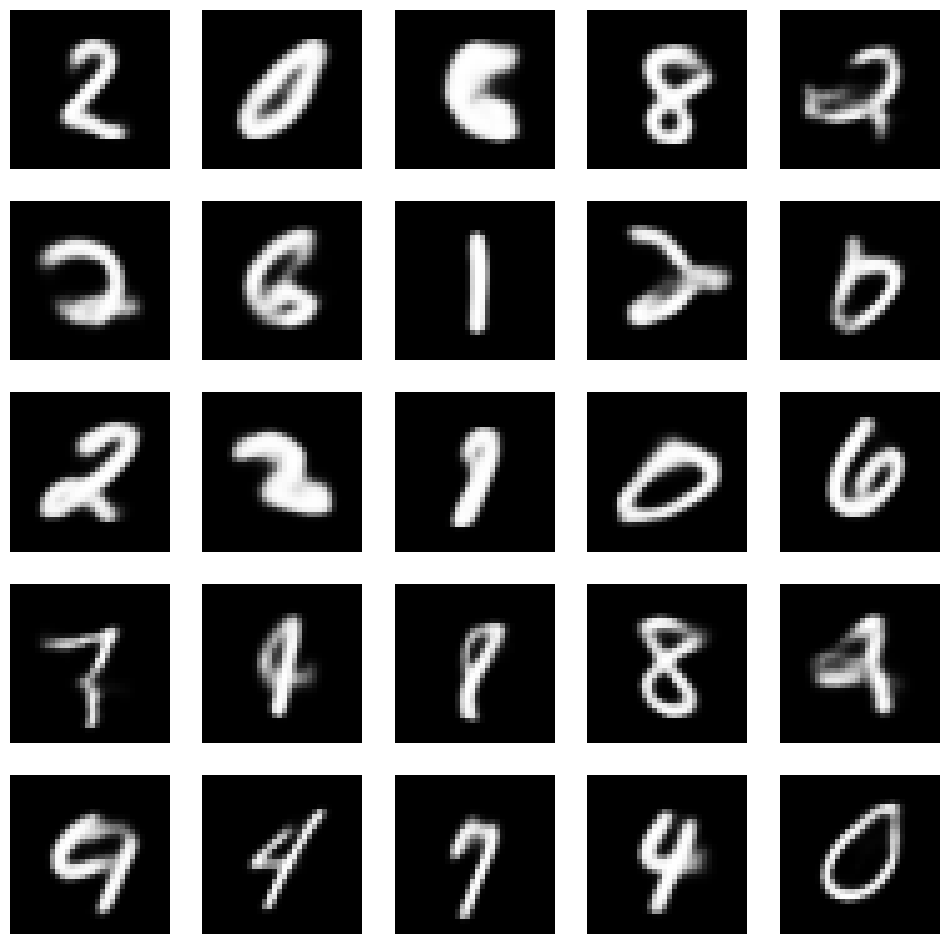

In [ ]:
# Generate N² examples

n_examples = 5 # squared

z_i = tf.random.normal([n_examples**2, latent_dim], 0.0, 1.0)
synth_batch = decoder_model(z_i)

fig, axes = plt.subplots(n_examples, n_examples, figsize=(12, 12))
ax = axes.ravel()
for j in range(n_examples**2):
    ax.ravel()[j].axis('off')
    ax.ravel()[j].imshow(denormalize_image(synth_batch[j]), cmap='gray')
plt.show()

In [ ]:
# Encode the original dataset

mean, log_variance = np.array([[[0.0 for i in range(latent_dim)]], [[0.0 for i in range(latent_dim)]]])
label = np.array([])

for i, batch in enumerate(mnist['train']\
                            .map(lambda data: {'image': tf.pad(tf.reshape(data['image'], (28, 28, 1)), [[2, 2], [2, 2], [0, 0]]), 
                                               'label': data['label'] }, num_parallel_calls=tf.data.AUTOTUNE)\
                            .map(lambda data: {'image': (tf.cast(data['image'], tf.float32) / 255.0), 
                                               'label': data['label'] }, num_parallel_calls=tf.data.AUTOTUNE)\
                            .cache()\
                            .batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)\
                            .prefetch(tf.data.AUTOTUNE)):
    mu_i, logvar_i = tf.split(encoder_model(batch['image']), num_or_size_splits=2, axis=-1)

    mean = np.append(mean, mu_i.numpy(), axis=0)
    log_variance = np.append(log_variance, logvar_i.numpy(), axis=0)
    label = np.append(label, batch['label'].numpy())

mean = mean[1:]
log_variance = log_variance[1:]

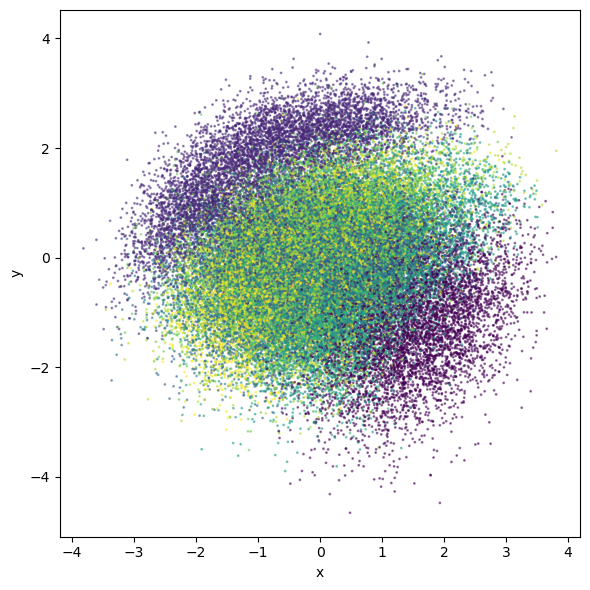

In [ ]:
# Project the latent space onto a two-dimensional space

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(2, svd_solver='full'))])

X = np.random.normal(0., 1., log_variance.shape)
Z = mean + np.exp(log_variance * 0.5) * X

latent_space_2d = pipeline.fit_transform(Z)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(latent_space_2d[:,0], latent_space_2d[:,1], c=label, alpha=0.5, s=1.)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
# Downsample the encoded dataset and store it in a pandas DataFrame
latent_df = pd.DataFrame(np.c_[Z, label][::6], columns=[f'gaussian{i+1}' for i in range(mean.shape[1])] + ['label'])

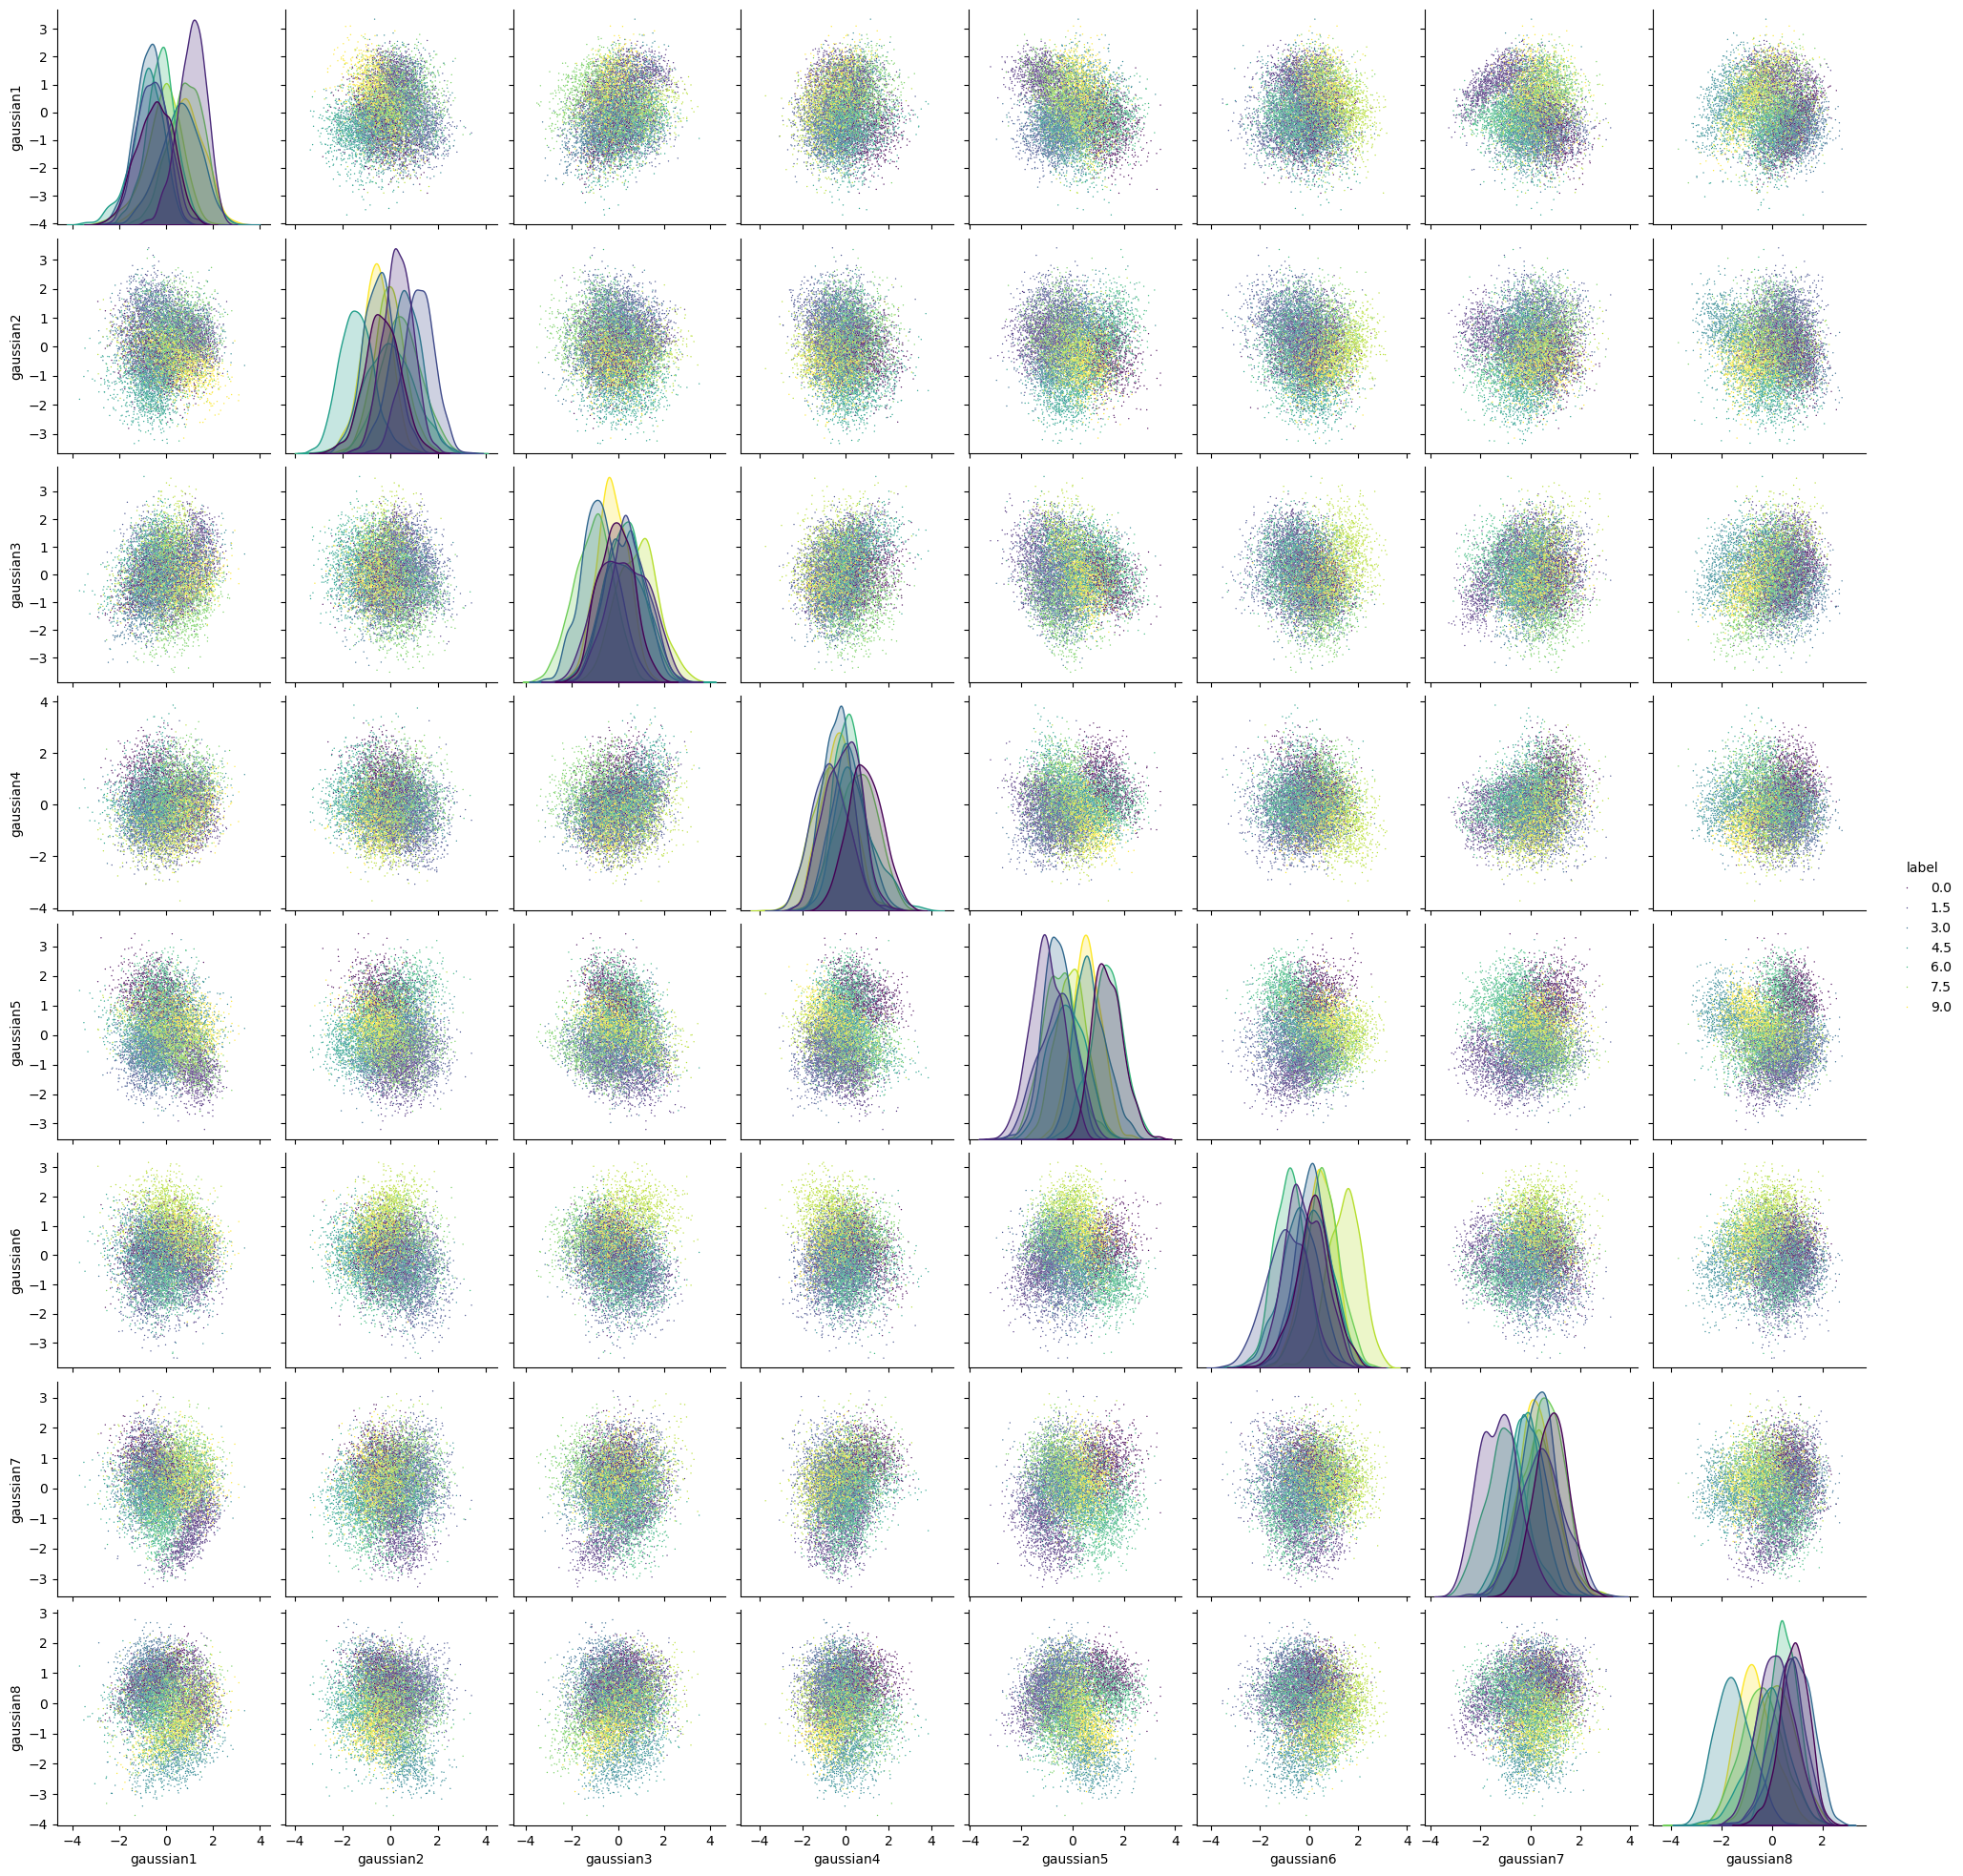

In [ ]:
# Plot each of the individual gaussians
sns.pairplot(data=latent_df, hue='label', plot_kws={"s": 1}, palette='viridis')
plt.show()

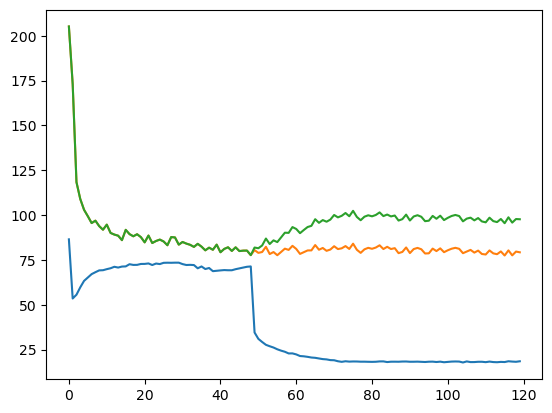

In [ ]:
# Quick sketch of the losses

plt.plot(np.asarray(history[::]))
# plt.xscale("log")
# plt.yscale("log")
plt.show()